# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import dlib
import face_recognition
import numpy as np
import seaborn as sns
from PIL import Image
import os
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
import pickle
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage import io
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from concurrent.futures import ProcessPoolExecutor, as_completed


# Understand the Data

In [ ]:
meta_df = pd.read_csv("/content/meta.csv")
meta_df.head()

,name,images
0,Abdullah_Gul,19
1,Adrien_Brody,12
2,Albert_Costa,6
3,Alejandro_Toledo,39
4,Ali_Naimi,8


In [ ]:
meta_df.describe()

,images
count,285.000000
mean,17.522807
std,36.715652
min,6.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,530.000000


In [ ]:
meta_df['name'].count()

285

In [ ]:
meta_df['images'].sum()

4994

In [ ]:
image_folder = "../data/lfw-limited/"
subfolders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
print("Subfolders (Individuals):", subfolders)

Subfolders (Individuals): ['Abdullah_Gul', 'Adrien_Brody', 'Albert_Costa', 'Alejandro_Toledo', 'Ali_Naimi', 'Alvaro_Uribe', 'Al_Gore', 'Al_Sharpton', 'Amelia_Vega', 'Amelie_Mauresmo', 'Ana_Guevara', 'Ana_Palacio', 'Andre_Agassi', 'Andy_Roddick', 'Angela_Bassett', 'Angelina_Jolie', 'Anna_Kournikova', 'Ann_Veneman', 'Antonio_Palocci', 'Ariel_Sharon', 'Ari_Fleischer', 'Arminio_Fraga', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Ben_Affleck', 'Billy_Crystal', 'Bill_Clinton', 'Bill_Frist', 'Bill_Gates', 'Bill_Graham', 'Bill_McBride', 'Bill_Simon', 'Binyamin_Ben-Eliezer', 'Bob_Graham', 'Bob_Hope', 'Bob_Stoops', 'Boris_Becker', 'Britney_Spears', 'Bulent_Ecevit', 'Calista_Flockhart', 'Cameron_Diaz', 'Carlos_Menem', 'Carlos_Moya', 'Carmen_Electra', 'Catherine_Zeta-Jones', 'Celine_Dion', 'Cesar_Gaviria', 'Charles_Moose', 'Charles_Taylor', 'Charlton_Heston', 'Christine_Todd_Whitman', 'Clay_Aiken', 'Clint_Eastwood', 'Colin_Farrell', 'Colin_Powell', 'Condoleezza_Rice', 'Costas_Simitis', 'Davi

In [ ]:
sample_folder = os.path.join(image_folder, subfolders[0])
sample_images = os.listdir(sample_folder)
print(f"Sample images from '{subfolders[0]}':", sample_images[:5])

Sample images from 'Abdullah_Gul': ['Abdullah_Gul_0001.jpg', 'Abdullah_Gul_0002.jpg', 'Abdullah_Gul_0003.jpg', 'Abdullah_Gul_0004.jpg', 'Abdullah_Gul_0005.jpg']


In [ ]:
def display_image_with_name(folder, image_name):
    image_path = os.path.join(image_folder, folder, image_name)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(folder)
    plt.axis('off')
    plt.show()

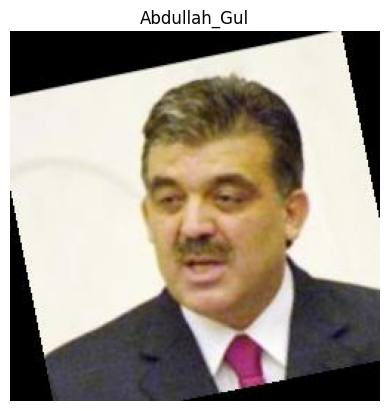

In [ ]:
first_folder = meta_df['name'].iloc[0]
sample_image_name = os.listdir(os.path.join(image_folder, first_folder))[0]
display_image_with_name(first_folder, sample_image_name)

In [ ]:
def check_image_details(image_path):
    image = cv2.imread(image_path)
    print(f"Image Path: {image_path}")
    print(f"Image Shape: {image.shape}")
    print(f"Image Data Type: {image.dtype}")
check_image_details(sample_image_path)

Image Path: ../data/test.png
Image Shape: (362, 665, 3)
Image Data Type: uint8


# Pre-processing


In [ ]:
def preprocess_images_dlib(image_folder, output_folder, target_size=(256, 256)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    detector = dlib.get_frontal_face_detector()

    for sub_folder in os.listdir(image_folder):
        sub_folder_path = os.path.join(image_folder, sub_folder)
        output_sub_folder_path = os.path.join(output_folder, sub_folder)

        if not os.path.exists(output_sub_folder_path):
            os.makedirs(output_sub_folder_path)

        for filename in os.listdir(sub_folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(sub_folder_path, filename)
                image = cv2.imread(image_path)
                if image is None:
                    continue

                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = detector(gray_image)

                for face in faces:
                    x, y, w, h = (face.left(), face.top(), face.width(), face.height())

                    if x < 0 or y < 0 or x+w > image_rgb.shape[1] or y+h > image_rgb.shape[0]:
                        continue

                    face_img = image_rgb[y:y+h, x:x+w]

                    if face_img.size == 0:
                        continue

                    face_resized = cv2.resize(face_img, target_size)
                    face_normalized = face_resized / 255.0

                    output_image_path = os.path.join(output_sub_folder_path, filename)
                    cv2.imwrite(output_image_path, cv2.cvtColor((face_normalized * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

image_folder = "../data/lfw-limited/"
output_folder = "../data/processed"
preprocess_images_dlib(image_folder, output_folder)

In [ ]:
def plot_random_images(output_folder, num_images=10):
    image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(output_folder) for f in filenames if f.endswith(('.jpg', '.png'))]
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(selected_images):
        image = cv2.imread(image_path)
        if image is not None:
            plt.subplot(num_images, 2, i*2 + 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Shape: {image.shape}")

            plt.subplot(num_images, 2, i*2 + 2)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap='gray')
            plt.axis('off')
            plt.title(f"Shape: {image.shape}")

    plt.tight_layout()
    plt.show()

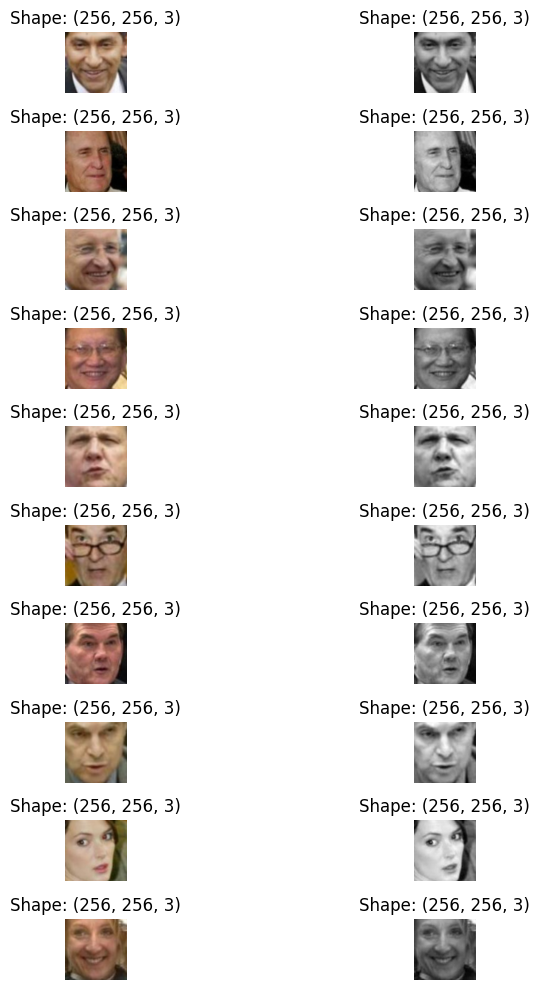

In [ ]:
test_fldr = "../data/processed"
plot_random_images(test_fldr, num_images=10)

# Feature Engineering

In [ ]:
detector = dlib.get_frontal_face_detector()
def detect_faces_dlib(image_path, name):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found at path {image_path}")
        return
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray_image)
    for face in faces:
        x, y, w, h = (face.left(), face.top(), face.width(), face.height())
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(image, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

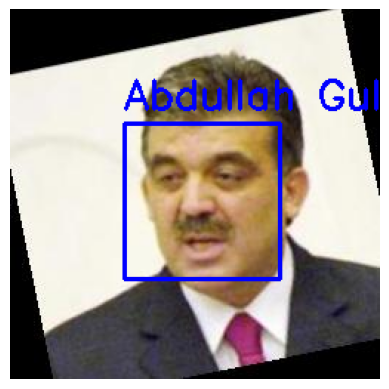

In [ ]:
sample_image_path = "../data/lfw-limited/Abdullah_Gul/Abdullah_Gul_0001.jpg"
name = "Abdullah Gul"
detect_faces_dlib(sample_image_path, name)

In [ ]:
# so this is the target we need to do

In [ ]:
# by using dlibs detector we can detect the face on the face this efficient for detection of the face
# lets check with multiple face as our testcase

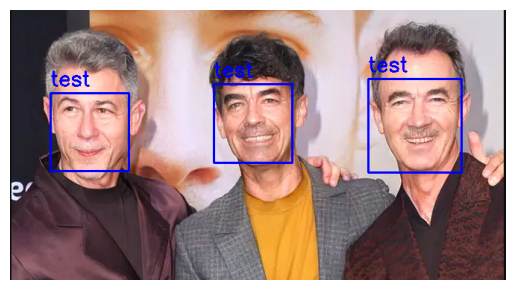

In [ ]:
sample_image_path = "../data/test.png"
name = "test"
detect_faces_dlib(sample_image_path, name)

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
face_recognizer = dlib.face_recognition_model_v1('/content/dlib_face_recognition_resnet_model_v1.dat')

In [ ]:

def extract_face_features(image_path):
    img = io.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detections = detector(gray)

    if len(detections) == 0:
        return None

    for detection in detections:
        shape = predictor(gray, detection)
        face_descriptor = face_recognizer.compute_face_descriptor(img, shape)
        return np.array(face_descriptor)
    return None

def load_data_from_folders(data_folder):
    features = []
    labels = []

    for label in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, label)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                feature = extract_face_features(image_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(label)

    return np.array(features), np.array(labels)

data_folder = '/content/processed'
X, y = load_data_from_folders(data_folder)

# Split The Data

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 2924
Validation set size: 975
Test set size: 975


# MODEL Training

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(y_train_one_hot.shape[1], activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                     │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 285)                 │          73,245 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 270,621 (1.03 MB)

 Trainable params: 270,621 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train_one_hot,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val_one_hot))

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.1043 - loss: 5.2937 - val_accuracy: 0.1528 - val_loss: 4.4868
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1852 - loss: 4.4273 - val_accuracy: 0.2903 - val_loss: 4.0586
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2702 - loss: 4.0343 - val_accuracy: 0.3651 - val_loss: 3.4984
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3412 - loss: 3.4713 - val_accuracy: 0.4349 - val_loss: 2.8727
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3965 - loss: 3.0098 - val_accuracy: 0.5200 - val_loss: 2.3467
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4694 - loss: 2.4992 - val_accuracy: 0.5877 - val_loss: 1.8845
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5207 - loss: 2.1341 - val_accuracy: 0.6462 - val_loss: 1.5597
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5549 - loss: 1.8647 - val_accuracy: 0.7313 - val_loss

# Validation of data

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9265 - loss: 0.3484   
Test Loss: 0.3465
Test Accuracy: 0.9231


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

Classification Report:
                              precision    recall  f1-score   support

                Abdullah_Gul       1.00      0.75      0.86         4
                Adrien_Brody       1.00      1.00      1.00         2
                     Al_Gore       1.00      1.00      1.00         2
                 Al_Sharpton       1.00      1.00      1.00         2
                Albert_Costa       1.00      1.00      1.00         1
            Alejandro_Toledo       0.89      1.00      0.94         8
                   Ali_Naimi       1.00      1.00      1.00         1
                Alvaro_Uribe       1.00      1.00      1.00         7
                 Amelia_Vega       1.00      1.00      1.00         1
             Amelie_Mauresmo       1.00      1.00      1.00         4
                 Ana_Guevara       1.00      1.00      1.00         2
                 Ana_Palacio       1.00      1.00      1.00         1
                Andre_Agassi       1.00      1.00      1.00       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


# Result Analysis

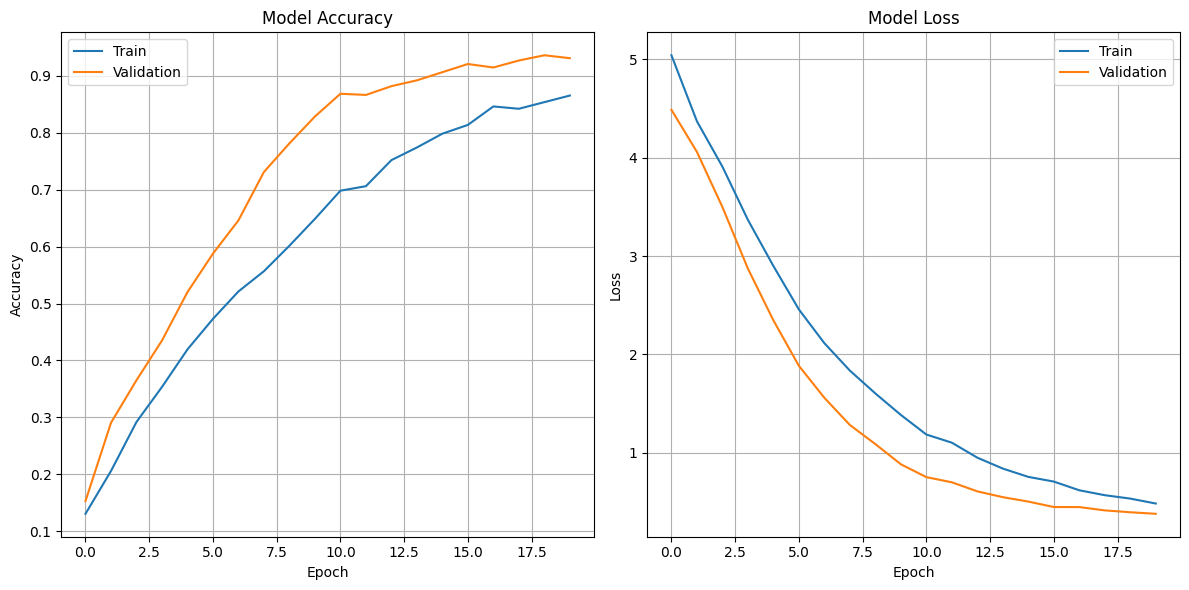

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/face_recognition_model.h5')
joblib.dump(label_encoder, '/content/label_encoder.pkl')

['/content/label_encoder.pkl']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


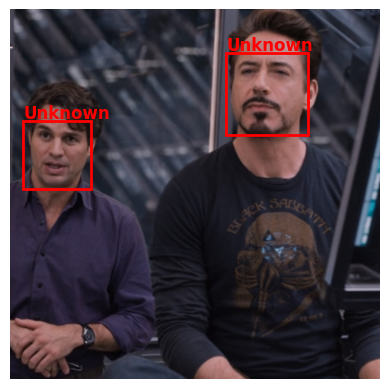

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
import dlib
from tensorflow.keras.models import load_model
import joblib

model = load_model('/content/drive/MyDrive/Copy of face_recognition_model.h5')
label_encoder = joblib.load('/content/drive/MyDrive/Copy of label_encoder.pkl')

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Copy of shape_predictor_68_face_landmarks.dat')
face_rec_model = dlib.face_recognition_model_v1('/content/drive/MyDrive/Copy of dlib_face_recognition_resnet_model_v1.dat')

CONFIDENCE_THRESHOLD = 0.6

def extract_face_features(image, shape):
    if isinstance(image, np.ndarray) and image.ndim == 3 and image.shape[2] == 3:
        face_descriptor = face_rec_model.compute_face_descriptor(image, shape)
        return np.array(face_descriptor)
    else:
        raise ValueError("Image should be a numpy array with shape (H, W, 3)")

def preprocess_face(face_image, target_size=(128, 128)):
    """Resize and normalize face image."""
    face_image = cv2.resize(face_image, target_size)
    face_image = face_image / 255.0
    return face_image

def predict_face(image_path, model):
    """Detect faces, preprocess face images, and predict the face label."""
    img = io.imread(image_path)

    if img.shape[2] == 4:
        img = img[:, :, :3]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    detections = detector(gray)

    fig, ax = plt.subplots()
    ax.imshow(img)

    if len(detections) == 0:
        print("No faces detected")
        return

    for detection in detections:
        x, y, w, h = (detection.left(), detection.top(), detection.right(), detection.bottom())
        face_image = img[y:h, x:w]

        face_image = preprocess_face(face_image, target_size=(128, 128))

        shape = predictor(gray, detection)
        face_features = extract_face_features(img, shape)

        if face_features is not None:
            face_features = face_features.reshape(1, -1)
            pred_prob = model.predict(face_features)
            predicted_label_index = np.argmax(pred_prob)
            predicted_confidence = np.max(pred_prob)
            predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]

            if predicted_confidence > CONFIDENCE_THRESHOLD:
                rect = plt.Rectangle((x, y), w-x, h-y, fill=False, edgecolor='green', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y - 10, f"{predicted_label} ({predicted_confidence:.2f})", color='green', fontsize=12, weight='bold')
            else:
                rect = plt.Rectangle((x, y), w-x, h-y, fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y - 10, "Unknown", color='red', fontsize=12, weight='bold')
        else:
            rect = plt.Rectangle((x, y), w-x, h-y, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x, y - 10, "Error", color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

image_path = "/content/asa.jpeg"
predict_face(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


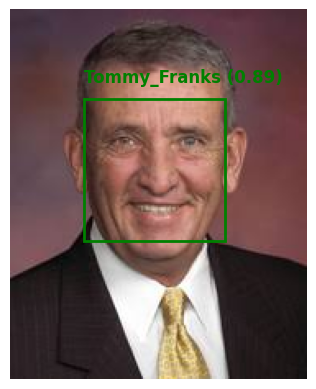

In [22]:
image_path = "/content/download.jpeg"
predict_face(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


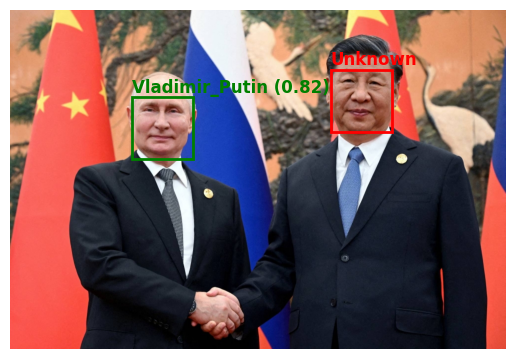

In [25]:
image_path = "/content/asaa.jpeg"
predict_face(image_path, model)